In [1]:
library(tidyverse)
library(magrittr)





── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [6]:
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  if (length(tokens) == 10)
    return(NULL)
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
               byrow = TRUE), tmp)
}



readData = function(file_path , subMacs=NULL){
  txt = readLines(file_path)
  unlist(lapply(strsplit(txt[4], ";")[[1]],
                function(x)
                  sapply(strsplit(x, "=")[[1]], strsplit, ",")))
  tokens = strsplit(txt[4], "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  lines = txt[ substr(txt, 1, 1) != "#" ]
  tmp = lapply(lines, processLine)
  records = as.data.frame(do.call("rbind", tmp),stringsAsFactors = FALSE)
  names(records) = c("time", "scanMac", "posX", "posY", "posZ",
                     "orientation", "mac", "signal",
                     "channel", "type")
  numVars = c("time", "posX", "posY", "posZ",
              "orientation", "signal")
  records[ numVars ] = lapply(records[ numVars ], as.numeric)
  records = records[ records$type == "3", ]
  records = records[ , "type" != names(records) ]
  records$rawTime = records$time
  records$time = records$time/1000
  class(records$time) = c("POSIXt", "POSIXct")
  records = records[ , !(names(records) %in% c("scanMac", "posZ"))]
  records$angle = roundOrientation(records$orientation)
  if (is.null(subMacs)){
  subMacs = names(sort(table(records$mac), decreasing = TRUE))[1:7]
  }
  records = records[ records$mac %in% subMacs, ]
  records = records[ , "channel" != names(records)]
  records
} 

surfaceSS = function(data, mac, angle){
  
  oneAPAngle = subset(data,
                      mac == mac & angle == angle)
  
  smoothSS = Tps(oneAPAngle[, c("posX","posY")],
                 oneAPAngle$avgSignal)
  
  
  vizSmooth = predictSurface(smoothSS)
  
  plot.surface(vizSmooth, type = "C")
  
  
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)
  
}

In [4]:
offline_file_path = "/Users/pankaj/dev/git/smu/qtw/data/offline.final.trace.txt"
online_file_path = "/Users/pankaj/dev/git/smu/qtw/data/online.final.trace.txt"

In [7]:
offline = readData(offline_file_path)

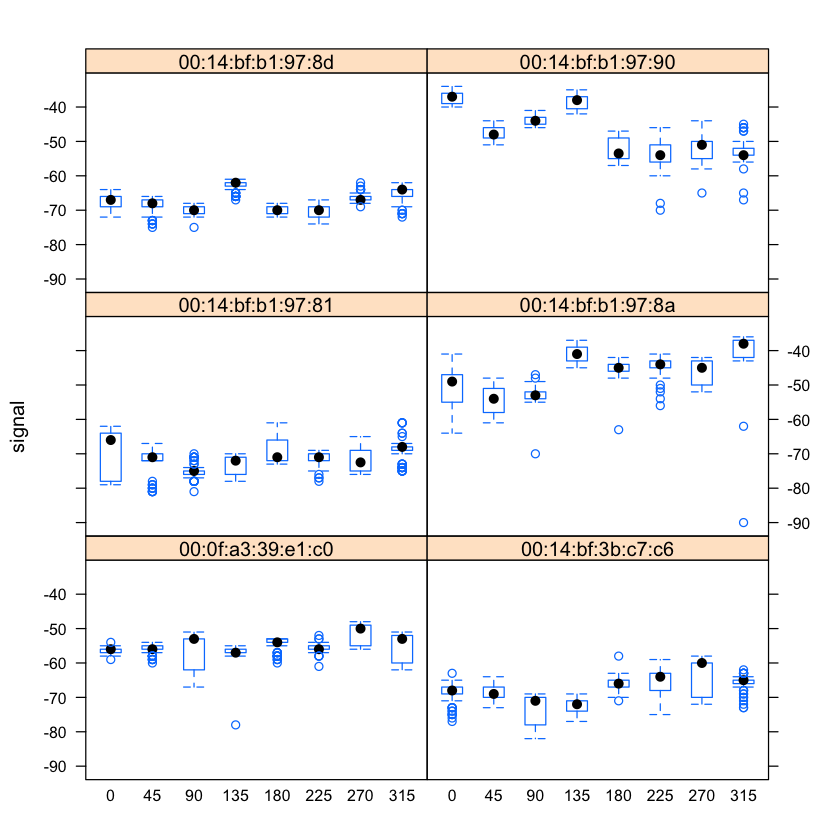

In [8]:
library(lattice)
 bwplot(signal ~ factor(angle) | mac, data = offline,
        subset = posX == 2 & posY == 12
        & mac != "00:0f:a3:39:dd:cd",
        layout = c(2,3))
 
 

In [ ]:
summary(offline$signal)
 
 

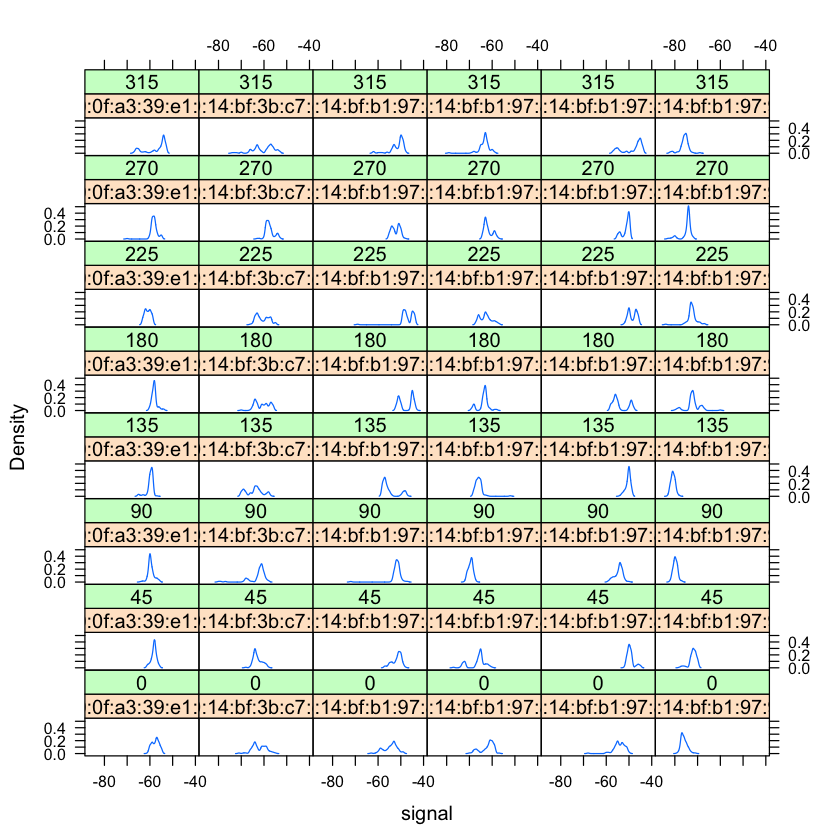

In [9]:
densityplot( ~ signal | mac + factor(angle), data = offline,
              subset = posX == 24 & posY == 4 &
                mac != "00:0f:a3:39:dd:cd",
              bw = 0.5, plot.points = FALSE)
 


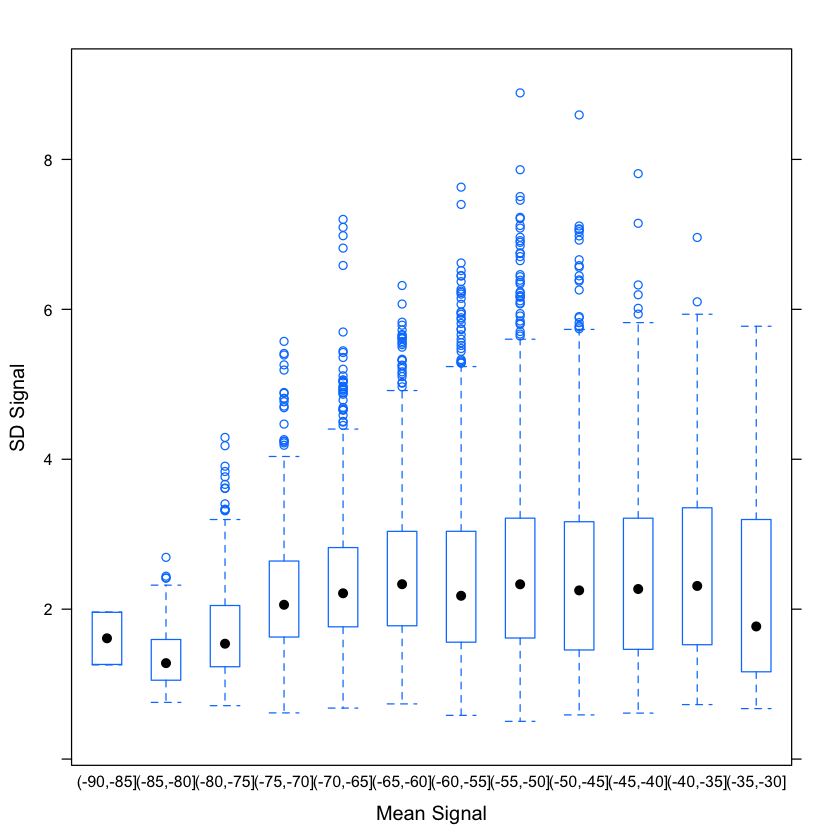

In [10]:
 offline$posXY = paste(offline$posX, offline$posY, sep = "-")
 
 
 byLocAngleAP = with(offline,
                     by(offline, list(posXY, angle, mac),
                        function(x) x))
 # Then we can calculate summary statistics on each of these data frames with
 signalSummary =
   lapply(byLocAngleAP,
          function(oneLoc) {
            ans = oneLoc[1, ]
            ans$medSignal = median(oneLoc$signal)
            ans$avgSignal = mean(oneLoc$signal)
            ans$num = length(oneLoc$signal)
            ans$sdSignal = sd(oneLoc$signal)
            ans$iqrSignal = IQR(oneLoc$signal)
            ans
          })
 offlineSummary = do.call("rbind", signalSummary)
 
 breaks = seq(-90, -30, by = 5)
 bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
        data = offlineSummary,
        subset = mac != "00:0f:a3:39:dd:cd",
        xlab = "Mean Signal", ylab = "SD Signal")

 
 

In [14]:
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]

oneAPAngle = subset(offline, mac == subMacs[5] & angle == 0)
 
 oneAPAngle = subset(offlineSummary,
                     mac == subMacs[5] & angle == 0)
 
 library(fields)
 smoothSS = Tps(oneAPAngle[, c("posX","posY")],
                oneAPAngle$avgSignal)

 
 vizSmooth = predictSurface(smoothSS)
 
 plot.surface(vizSmooth, type = "C")
 
 
 

ERROR: Error in library(fields): there is no package called ‘fields’


In [15]:
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)
 
 

 
 surfaceSS(data = offlineSummary, mac == subMacs[5] & angle == 0)
 
 
 parCur = par(mfrow = c(2,2), mar = rep(1, 4))
 
    mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ],
          angle = rep(c(0, 135), 2),
          data = list(data = offlineSummary))
    
  par(parCur)
  
  offlineSummary = subset(offlineSummary, mac != subMacs[2])
 
  AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,
                  1, 14, 33.5, 9.3, 33.5, 2.8),
               ncol = 2, byrow = TRUE,
               dimnames = list(subMacs[ -2 ], c("x", "y") ))

  AP
  
  
  diffs = offlineSummary[ , c("posX", "posY")] -
    AP[ offlineSummary$mac, ]

  
  offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)
  
  
  xyplot(signal ~ dist | factor(mac) + factor(angle),
         data = offlineSummary, pch = 19, cex = 0.3,
         xlab ="distance")

  macs = unique(offlineSummary$mac)
  

ERROR: Error in plot.xy(xy.coords(x, y), type = type, ...): plot.new has not been called yet
